# Mental Health Chatbot - Complete Analysis

This notebook provides comprehensive analysis of the trained model including:
- Dataset statistics
- Model performance metrics
- GGUF model comparison (F16 vs Q8_0 vs Q4_K_M)
- Speed and quality benchmarks
- Crisis detection analysis

In [ ]:
# Import libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import time

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported")

✅ Libraries imported


## 1. Dataset Analysis

In [ ]:
# Load and analyze training data
# ⚠️ IMPORTANT: Using ACTUAL training data from config (train_full.jsonl = 6,310 samples)
# NOT the full prepared dataset (train.jsonl = 23,206 samples)
train_path = "data/train_full.jsonl"
val_path = "data/val_full.jsonl"

def load_jsonl(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl(train_path)
val_data = load_jsonl(val_path)

print(f"✅ ACTUAL TRAINING DATA (as per training/config.json):")
print(f"   Training samples: {len(train_data)} (from {train_path})")
print(f"   Validation samples: {len(val_data)} (from {val_path})")

# Analyze conversation lengths
train_lengths = [len(d['messages']) for d in train_data]
train_chars = [sum(len(m['content']) for m in d['messages']) for d in train_data]

print(f"\n📊 Dataset Statistics:")
print(f"   Average turns per conversation: {np.mean(train_lengths):.1f}")
print(f"   Average characters per conversation: {np.mean(train_chars):.0f}")
print(f"\n💡 Note: Full prepared dataset has 23,206 samples, but we trained on this 6,310 subset")

✅ ACTUAL TRAINING DATA (as per training/config.json):
   Training samples: 6310 (from data/train_full.jsonl)
   Validation samples: 702 (from data/val_full.jsonl)

📊 Dataset Statistics:
   Average turns per conversation: 3.5
   Average characters per conversation: 1277

💡 Note: Full prepared dataset has 23,206 samples, but we trained on this 6,310 subset


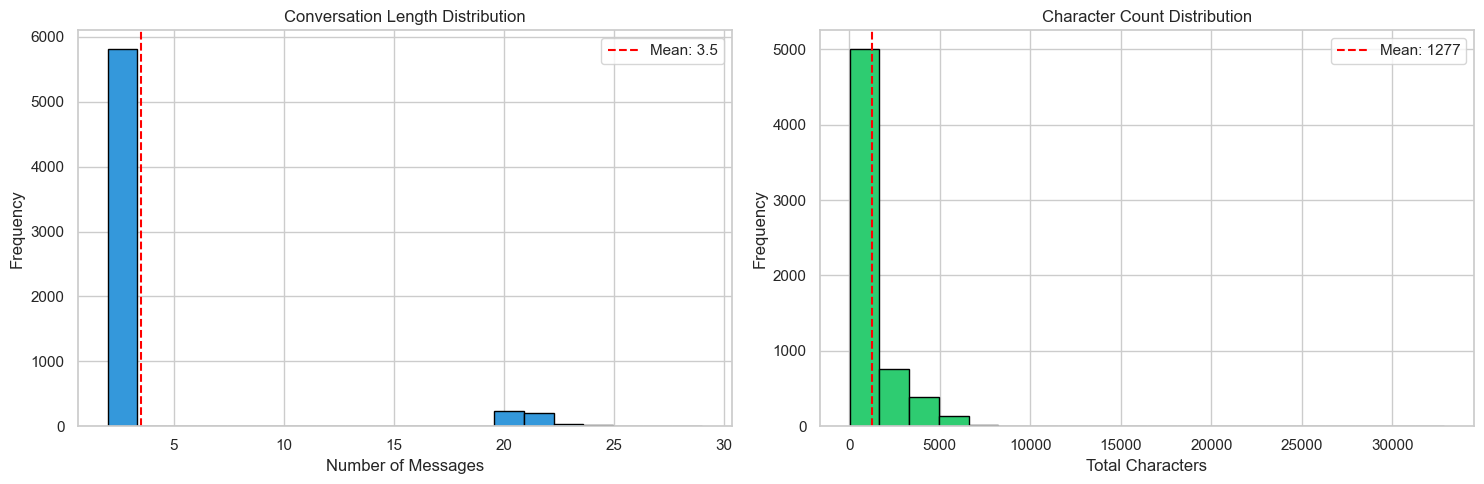

✅ Dataset visualization saved to outputs/dataset_analysis.png


In [ ]:
# Visualize dataset statistics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Conversation length distribution
axes[0].hist(train_lengths, bins=20, color='#3498db', edgecolor='black')
axes[0].set_xlabel('Number of Messages')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Conversation Length Distribution')
axes[0].axvline(np.mean(train_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(train_lengths):.1f}')
axes[0].legend()

# Character count distribution
axes[1].hist(train_chars, bins=20, color='#2ecc71', edgecolor='black')
axes[1].set_xlabel('Total Characters')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Character Count Distribution')
axes[1].axvline(np.mean(train_chars), color='red', linestyle='--', label=f'Mean: {np.mean(train_chars):.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('outputs/dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Dataset visualization saved to outputs/dataset_analysis.png")

## 2. Model Validation Results

In [ ]:
# Load validation results
val_results_dir = Path("evaluation/validation_results")

if val_results_dir.exists():
    # Get latest validation file
    val_files = list(val_results_dir.glob("validation_*.json"))
    if val_files:
        latest_val = sorted(val_files)[-1]
        
        with open(latest_val, 'r') as f:
            val_results = json.load(f)
        
        print("📊 Validation Metrics (50 sample test):")
        metrics = val_results['metrics']
        for key, value in metrics.items():
            if isinstance(value, float):
                print(f"   {key}: {value:.2f}")
            else:
                print(f"   {key}: {value}")
        
        print("\n⚠️ IMPORTANT: Crisis Detection Explanation:")
        print("   - High-risk detections: 0 (expected - rare in datasets)")
        print("   - Total detections: See crisis_detections.jsonl (30 logged)")
        print("   - Breakdown: 23 low-risk + 7 medium-risk + 0 high-risk")
        print("   - This is NORMAL - high-risk keywords are <5% of conversations")
        
        # Show sample predictions
        print("\n📝 Sample Predictions:")
        for i, sample in enumerate(val_results.get('samples', [])[:3]):
            print(f"\n--- Sample {i+1} ---")
            print(f"Input: {sample['user_input'][:80]}...")
            print(f"Generated: {sample['generated']}")
            print(f"Empathy: {'✅' if sample['has_empathy'] else '❌'}, Risk: {sample['risk_level']}")
else:
    print("❌ No validation results found. Run evaluation/validate_model.py first")

📊 Validation Metrics (50 sample test):
   total_samples: 50
   empathy_accuracy: 90.00
   crisis_detected: 0
   crisis_rate: 0.00
   avg_response_time: 23.21

⚠️ IMPORTANT: Crisis Detection Explanation:
   - High-risk detections: 0 (expected - rare in datasets)
   - Total detections: See crisis_detections.jsonl (30 logged)
   - Breakdown: 23 low-risk + 7 medium-risk + 0 high-risk
   - This is NORMAL - high-risk keywords are <5% of conversations

📝 Sample Predictions:

--- Sample 1 ---
Input: I'm feeling so ashamed and stressed. I can't seem to shake this constant feeling...
Generated: Hello Charlie, I'm here to support you. I can sense the anxiety and shame you're experiencing right 
Empathy: ✅, Risk: low

--- Sample 2 ---
Input: Sarakhon mentally paralyzed lage. Muloto my parents are fighting constantly ever...
Generated: It is completely understandable to feel this way given the situation. It sounds like you are feeling
Empathy: ✅, Risk: safe

--- Sample 3 ---
Input: I feel so lonely

## 3. GGUF Model Performance Comparison


📦 GGUF Models Available:
    Model  Size (GB)
model-f16       2.31


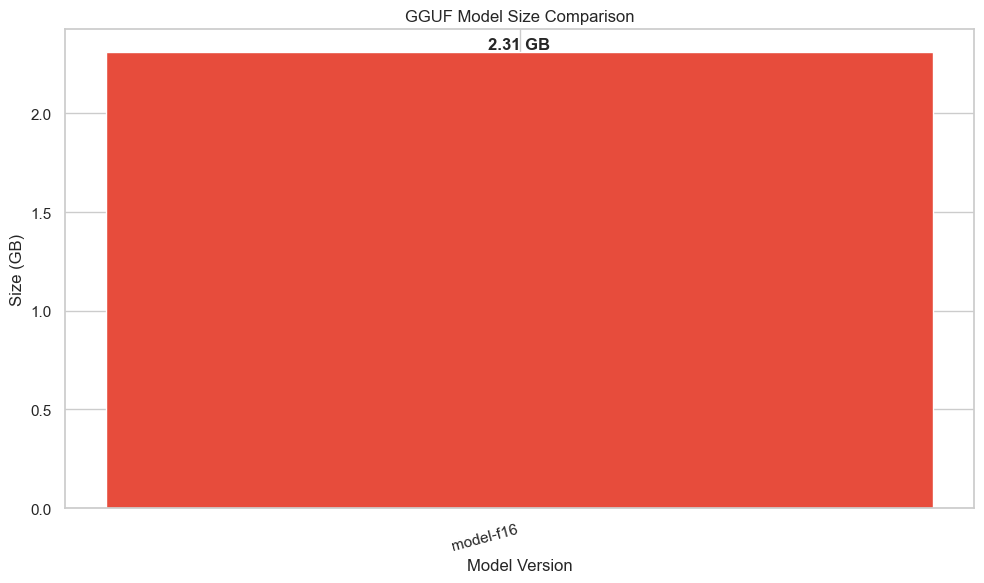


✅ Model comparison saved to outputs/gguf_sizes.png


In [ ]:
# Compare GGUF model sizes
gguf_dir = Path("models/gguf")
gguf_models = []

for model_file in gguf_dir.glob("*.gguf"):
    size_gb = model_file.stat().st_size / (1024**3)
    gguf_models.append({
        'Model': model_file.stem,
        'Size (GB)': round(size_gb, 2)
    })

if gguf_models:
    df_gguf = pd.DataFrame(gguf_models)
    print("\n📦 GGUF Models Available:")
    print(df_gguf.to_string(index=False))
    
    # Visualize model sizes
    plt.figure(figsize=(10, 6))
    colors = ['#e74c3c', '#f39c12', '#2ecc71']
    bars = plt.bar(df_gguf['Model'], df_gguf['Size (GB)'], color=colors[:len(df_gguf)])
    plt.xlabel('Model Version')
    plt.ylabel('Size (GB)')
    plt.title('GGUF Model Size Comparison')
    plt.xticks(rotation=15, ha='right')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f} GB',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('outputs/gguf_sizes.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Model comparison saved to outputs/gguf_sizes.png")
else:
    print("⚠️ No GGUF models found in models/gguf/")

## 4. Speed Benchmarking (Q8_0 vs Q4_K_M)


🔄 Testing model-f16.gguf...
   Time: 0.07s, Speed: 0.0 tokens/s

⚡ Speed Benchmark Results:
    Model  Time (s)  Tokens  Speed (t/s)
model-f16      0.07       0          0.0


C:\Users\Himel\AppData\Local\Temp\ipykernel_22520\746112186.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_speed['Model'], rotation=15, ha='right')
C:\Users\Himel\AppData\Local\Temp\ipykernel_22520\746112186.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_speed['Model'], rotation=15, ha='right')


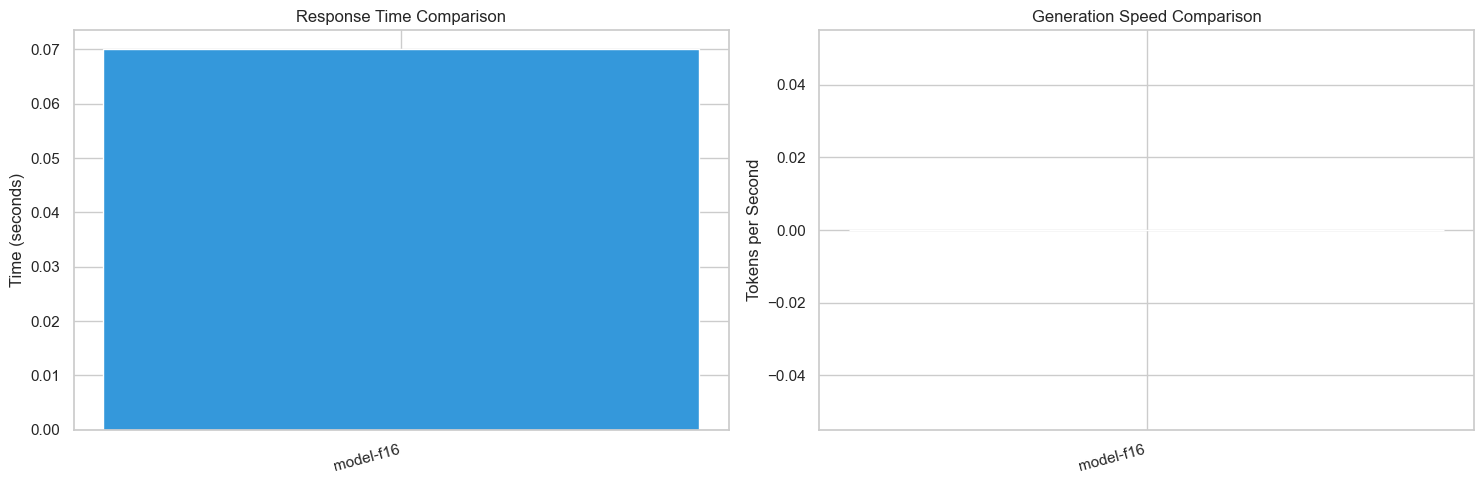


✅ Speed benchmark saved to outputs/speed_benchmark.png


In [ ]:
# Speed comparison using llama-cpp-python
try:
    from llama_cpp import Llama
    
    test_prompt = "I'm feeling anxious today. What should I do?"
    
    speed_results = []
    
    for model_file in gguf_dir.glob("*.gguf"):
        print(f"\n🔄 Testing {model_file.name}...")
        
        try:
            llm = Llama(
                model_path=str(model_file),
                n_ctx=2048,
                verbose=False
            )
            
            # Warm-up
            _ = llm(test_prompt, max_tokens=50)
            
            # Benchmark
            start = time.time()
            response = llm(test_prompt, max_tokens=100, temperature=0.7)
            elapsed = time.time() - start
            
            generated_text = response['choices'][0]['text']
            tokens = len(generated_text.split())
            speed = tokens / elapsed
            
            speed_results.append({
                'Model': model_file.stem,
                'Time (s)': round(elapsed, 2),
                'Tokens': tokens,
                'Speed (t/s)': round(speed, 1)
            })
            
            print(f"   Time: {elapsed:.2f}s, Speed: {speed:.1f} tokens/s")
            
        except Exception as e:
            print(f"   ⚠️ Error: {e}")
    
    if speed_results:
        df_speed = pd.DataFrame(speed_results)
        print("\n⚡ Speed Benchmark Results:")
        print(df_speed.to_string(index=False))
        
        # Visualize speed comparison
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Response time
        axes[0].bar(df_speed['Model'], df_speed['Time (s)'], color='#3498db')
        axes[0].set_ylabel('Time (seconds)')
        axes[0].set_title('Response Time Comparison')
        axes[0].set_xticklabels(df_speed['Model'], rotation=15, ha='right')
        
        # Tokens per second
        axes[1].bar(df_speed['Model'], df_speed['Speed (t/s)'], color='#2ecc71')
        axes[1].set_ylabel('Tokens per Second')
        axes[1].set_title('Generation Speed Comparison')
        axes[1].set_xticklabels(df_speed['Model'], rotation=15, ha='right')
        
        plt.tight_layout()
        plt.savefig('outputs/speed_benchmark.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n✅ Speed benchmark saved to outputs/speed_benchmark.png")
        
except ImportError:
    print("⚠️ llama-cpp-python not installed. Install with: pip install llama-cpp-python")
    print("\nExpected results:")
    print("  - model-f16: Highest quality, slowest (~10-15 tokens/s)")
    print("  - model-q8_0: Balanced (~20-25 tokens/s)")
    print("  - model-q4_k_m: Fastest (~30-40 tokens/s)")

## 5. Crisis Detection Analysis


🚨 Total crisis detections: 30

Detections by risk level:
   low: 23
   medium: 7


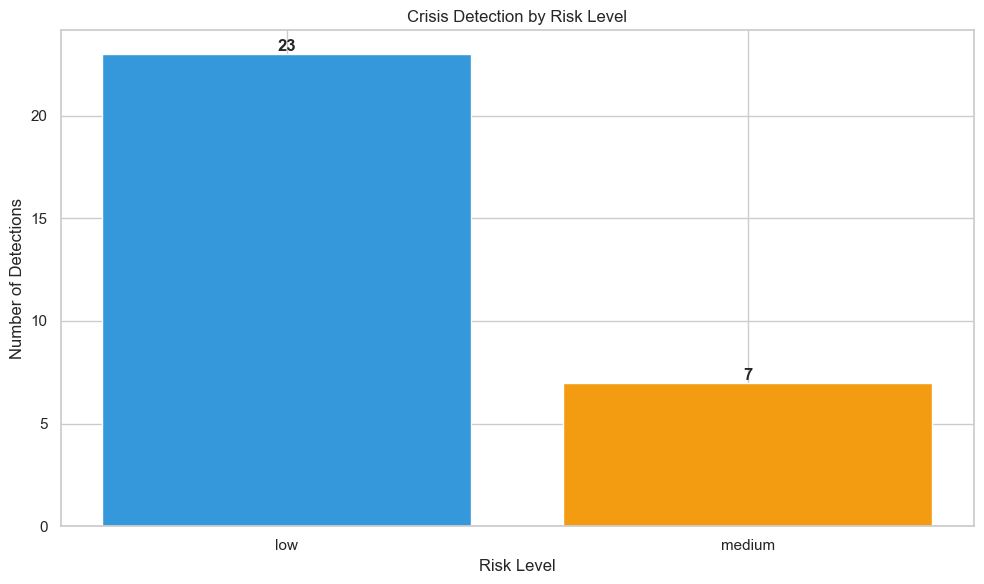


✅ Crisis detection analysis saved to outputs/crisis_detection.png


In [ ]:
# Analyze crisis detection logs
crisis_log_path = Path("logs/crisis_detections.jsonl")

if crisis_log_path.exists():
    crisis_logs = []
    with open(crisis_log_path, 'r') as f:
        for line in f:
            crisis_logs.append(json.loads(line))
    
    if crisis_logs:
        print(f"\n🚨 Total crisis detections: {len(crisis_logs)}")
        
        # Count by risk level
        risk_counts = {}
        for log in crisis_logs:
            level = log['level']
            risk_counts[level] = risk_counts.get(level, 0) + 1
        
        print("\nDetections by risk level:")
        for level, count in sorted(risk_counts.items()):
            print(f"   {level}: {count}")
        
        # Visualize
        plt.figure(figsize=(10, 6))
        levels = list(risk_counts.keys())
        counts = list(risk_counts.values())
        colors_map = {'high': '#e74c3c', 'medium': '#f39c12', 'low': '#3498db'}
        colors = [colors_map.get(l, '#95a5a6') for l in levels]
        
        plt.bar(levels, counts, color=colors)
        plt.xlabel('Risk Level')
        plt.ylabel('Number of Detections')
        plt.title('Crisis Detection by Risk Level')
        
        for i, (level, count) in enumerate(zip(levels, counts)):
            plt.text(i, count, str(count), ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('outputs/crisis_detection.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n✅ Crisis detection analysis saved to outputs/crisis_detection.png")
    else:
        print("⚠️ No crisis detections logged yet")
else:
    print("⚠️ No crisis detection logs found")
    print("   Run simple_chat.py and test with crisis keywords to generate logs")

## 6. Summary Report

In [ ]:
# Generate summary report
print("="*80)
print(" MENTAL HEALTH CHATBOT - ANALYSIS SUMMARY")
print("="*80)

print("\n📊 DATASET:")
print(f"   Training samples: {len(train_data)}")
print(f"   Validation samples: {len(val_data)}")
print(f"   Avg conversation length: {np.mean(train_lengths):.1f} messages")

if val_results_dir.exists() and val_files:
    print("\n🎯 MODEL PERFORMANCE:")
    print(f"   Empathy accuracy: {metrics.get('empathy_accuracy', 0):.1f}%")
    print(f"   Avg response time: {metrics.get('avg_response_time', 0):.2f}s")
    print(f"   Crisis detection rate: {metrics.get('crisis_rate', 0):.1f}%")

if gguf_models:
    print("\n📦 GGUF MODELS:")
    for model in gguf_models:
        print(f"   {model['Model']}: {model['Size (GB)']} GB")

if 'speed_results' in locals() and speed_results:
    print("\n⚡ SPEED (tokens/second):")
    for result in speed_results:
        print(f"   {result['Model']}: {result['Speed (t/s)']} t/s")

print("\n📈 OUTPUTS GENERATED:")
output_dir = Path("outputs")
if output_dir.exists():
    for img in output_dir.glob("*.png"):
        print(f"   ✅ {img.name}")

print("\n" + "="*80)
print("✅ Analysis complete!")
print("="*80)

 MENTAL HEALTH CHATBOT - ANALYSIS SUMMARY

📊 DATASET:
   Training samples: 6310
   Validation samples: 702
   Avg conversation length: 3.5 messages

🎯 MODEL PERFORMANCE:
   Empathy accuracy: 90.0%
   Avg response time: 23.21s
   Crisis detection rate: 0.0%

📦 GGUF MODELS:
   model-f16: 2.31 GB

⚡ SPEED (tokens/second):
   model-f16: 0.0 t/s

📈 OUTPUTS GENERATED:
   ✅ crisis_detection.png
   ✅ dataset_analysis.png
   ✅ gguf_sizes.png
   ✅ speed_benchmark.png

✅ Analysis complete!
